AE with dense layer

In [1]:
import numpy as np
import itertools
import os, sys
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from progressBar import ProgressBar
from utils import EarlyStopping

In [4]:
dnd = []

## Get the dataset

In [5]:
from torch.utils import data

In [6]:
class Dataset(data.Dataset):
    def __init__(self, names = 'SM', 
                 template='../data/20190625_10part_PtOrder/{}_lepFilter_13TeV.npy'):
        if names == 'SM':
            self.SM_names = ['Wlnu', 'qcd', 'ttbar', 'Zll']
            names = self.SM_names
        self.names = names
        
        self.feature_names = ['Pt', 'eta', 'phi', 'charge', 'pId'][:2]
        
        for i, n in enumerate(names):
            ins = np.load(template.format(n)).astype(np.float32)[:,:10,:2].reshape((-1, 20))
            lbs = i*np.ones(ins.shape[0]).astype(np.int8)
            
            print(n, ':', str(ins.shape[0]))
            
            if i == 0:
                self.inputs = ins
                self.labels = lbs
            else:
                self.inputs = np.concatenate((self.inputs, ins))
                self.labels = np.concatenate((self.labels, lbs))
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.inputs[idx]

In [7]:
dataset = {}
# Use to do validation split
# torch.utils.data.random_split(dataset, lengths)
dataset['train'] = Dataset(names=['Zll'], template='../data/20190626_20part_PtOrder_v1/{}_lepFilter_13TeV.npy')

Zll : 100000


## Define the model

In [8]:
class AEDenseNet(nn.Module):
    def __init__(self, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=self.p,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden):
        net = nn.Sequential(
                            nn.Linear(dim_in, dim_hidden),
                            nn.ReLU(),
#                             nn.Linear(dim_hidden, dim_hidden),
#                             nn.ELU(),
                            nn.Linear(dim_hidden, dim_out),
#                             nn.ELU(),
                          )
        return net
        
    def encode(self, x):
        z = self.encoder_modules['PhiE'](x)
        return z
    
    def decode(self, z):
        x = self.decoder_modules['PhiD'](z)
        return x
        
        # --- Formatting x ----
        # pt
        pt = 1 + F.elu(x[:,0])
        # eta
        eta = 5*F.tanh(x[:,1])
        # phi
#         x[:,:,2] = F.hardtanh(x[:,:,2], min_val=-3.14159, max_val=3.14159)
        # charge
#         x[:,:,3] = F.hardtanh(x[:,:,3], min_val=-1, max_val=2)
        # pId
#         x[:,:,4] = F.hardtanh(x[:,:,4], min_val=0, max_val=6)
        return torch.cat((pt,eta), 1)
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            
            for o in self.__dict__.values():
                if o.__class__ == torch.Tensor:
                    o.cuda()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [9]:
model = AEDenseNet(
                   N_features=dataset['train'].inputs.shape[1],
                   dim_hidden=10,
                   dim_latent=5
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=5, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (PhiD): Sequential(
      (0): Linear(in_features=5, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
    )
  )
)

Trainable parameters: 545


## Loss

In [10]:
criterion = nn.MSELoss()

## Training

In [11]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 0
                  }

max_epochs = 100

In [12]:
torch.autograd.set_detect_anomaly(True)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=2,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=5)

In [14]:
optimizer.zero_grad()
data_train_iter = data.DataLoader(dataset['train'], **training_params)

train_loss = []
for epoch in range(1, max_epochs+1):
    batch_loss = []
    pb = ProgressBar(len(data_train_iter), percentPrecision=5, headLabel='Ep {} '.format(epoch))
    for local_x, _ in data_train_iter:
        if model.onGPU:
            local_x = local_x.cuda()
        
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(train_loss) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - train_loss[-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)
        loss.backward()
        optimizer.step()
    
    aux_loss = 0
    N_batches = 0
    for local_x, _ in data_train_iter:
        loss = criterion(local_x, model(local_x))
        aux_loss += loss.item()
        N_batches += 1
    batch_loss.append(aux_loss/N_batches)
    
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(train_loss) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - train_loss[-1][-1])
    if len(train_loss) > 1:
        d2L_de2 = batch_loss[-1] - 2*train_loss[-1][-1] + train_loss[-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout+'\n')
    
    train_loss.append(batch_loss)
    
    if not earlyStopping.check(batch_loss[-1]):
        break

    scheduler.step(batch_loss[-1])

Ep 1 [##########]  100% - Tot. time: 1.6 s            
Loss: 5.73e+00

Ep 2 [##########]  100% - Tot. time: 1.5 s                        
Loss: 5.26e+00 - Delta: -4.71e-01

Ep 3 [##########]  100% - Tot. time: 1.4 s                        
Loss: 4.86e+00 - Delta: -3.98e-01 - Trend: 7.32e-02

Ep 4 [##########]  100% - Tot. time: 1.4 s                        
Loss: 4.54e+00 - Delta: -3.22e-01 - Trend: 7.61e-02

Ep 5 [##########]  100% - Tot. time: 1.4 s                        
Loss: 4.29e+00 - Delta: -2.54e-01 - Trend: 6.81e-02

Ep 6 [##########]  100% - Tot. time: 1.3 s                        
Loss: 4.08e+00 - Delta: -2.03e-01 - Trend: 5.01e-02

Ep 7 [##########]  100% - Tot. time: 1.4 s                        
Loss: 3.91e+00 - Delta: -1.72e-01 - Trend: 3.16e-02

Ep 8 [##########]  100% - Tot. time: 1.4 s                        
Loss: 3.77e+00 - Delta: -1.47e-01 - Trend: 2.51e-02

Ep 9 [##########]  100% - Tot. time: 1.3 s                        
Loss: 3.65e+00 - Delta: -1.15e-01 - Tren

Ep 68 [##########]  100% - Tot. time: 1.3 s                        
Loss: 2.71e+00 - Delta: -8.47e-04 - Trend: -3.11e-04

Ep 69 [##########]  100% - Tot. time: 1.4 s                        
Loss: 2.71e+00 - Delta: -1.17e-03 - Trend: -3.21e-04

Ep 70 [##########]  100% - Tot. time: 1.4 s                        
Loss: 2.71e+00 - Delta: -1.50e-03 - Trend: -3.28e-04

Ep 71 [##########]  100% - Tot. time: 1.4 s                        
Loss: 2.71e+00 - Delta: -1.82e-03 - Trend: -3.27e-04

Ep 72 [##########]  100% - Tot. time: 1.6 s                        
Loss: 2.70e+00 - Delta: -2.14e-03 - Trend: -3.21e-04

Ep 73 [##########]  100% - Tot. time: 1.4 s                        
Loss: 2.70e+00 - Delta: -2.46e-03 - Trend: -3.13e-04

Ep 74 [##########]  100% - Tot. time: 1.6 s                        
Loss: 2.70e+00 - Delta: -2.76e-03 - Trend: -2.98e-04

Ep 75 [##########]  100% - Tot. time: 1.6 s                        
Loss: 2.70e+00 - Delta: -3.04e-03 - Trend: -2.81e-04

Ep 76 [##########]  100%

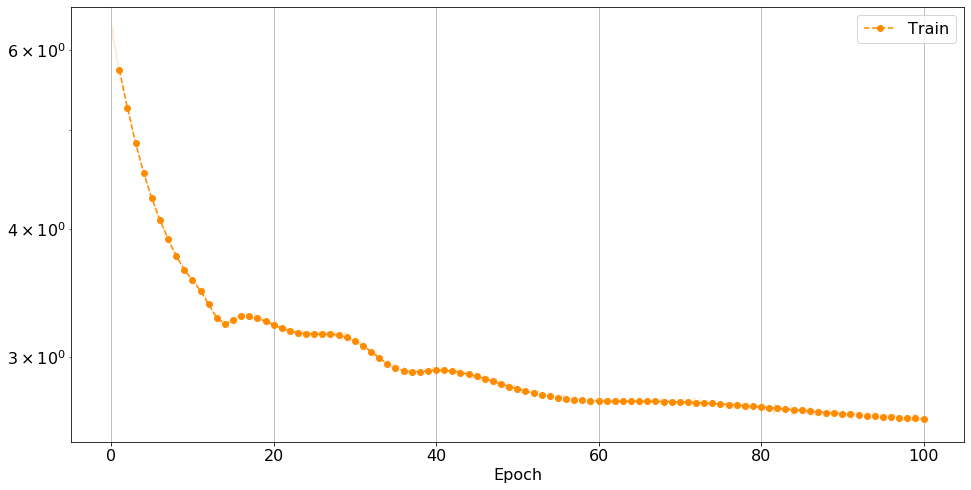

In [15]:
train_loss = np.array(train_loss)
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(16,8))

train_loss_flat = train_loss.flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(train_loss.shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, train_loss.shape[0]+1)
plt.plot(x, train_loss[:,-1], 'o--', label='Train', color='darkorange')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
# f.savefig('plots/TrainingHistory_VAE_all-in-one_v'+VAEversion+'.png')

# f = open('TrainingHistory_VAE_all-in-one_v'+VAEversion+'.pkl', 'w')
# pickle.dump(fit_report.history, f, pickle.HIGHEST_PROTOCOL)
# f.close()

# Convergence check

In [16]:
x = dataset['train'].inputs
model.eval()
x_prime = model(torch.from_numpy(dataset['train'].inputs[:10000])).cpu().detach().numpy()
z = model.encode(torch.from_numpy(dataset['train'].inputs[:10000])).cpu().detach().numpy()

### Latent space

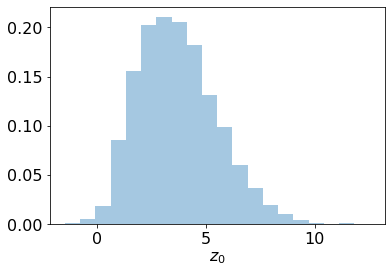

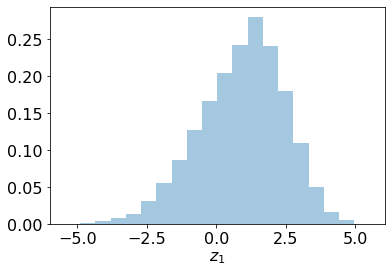

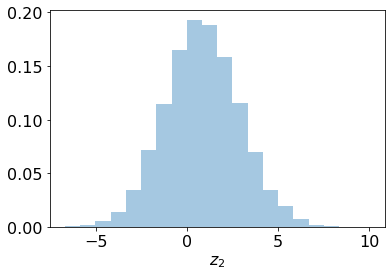

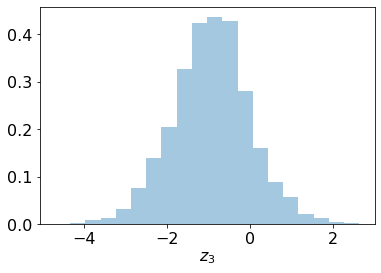

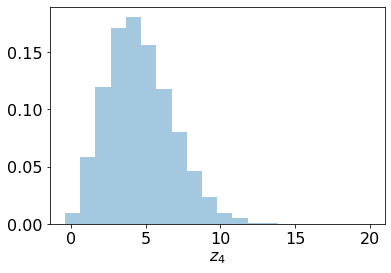

In [17]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{}$'.format(i))
    dnd.append(f)

### Output features

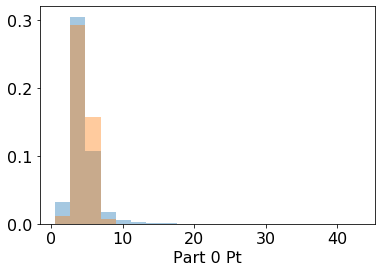

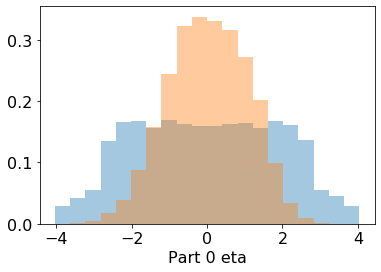

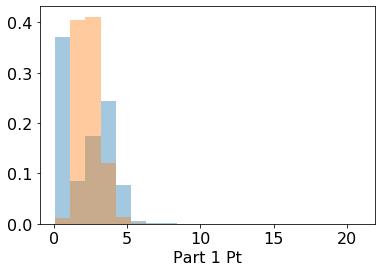

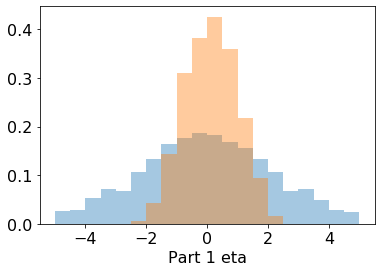

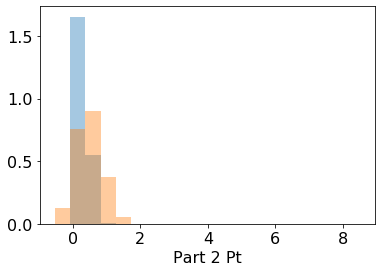

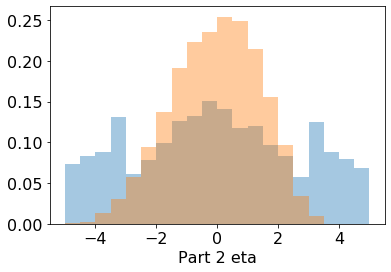

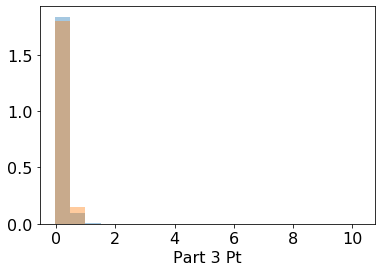

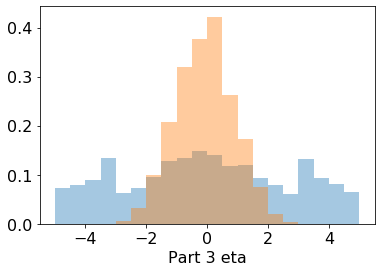

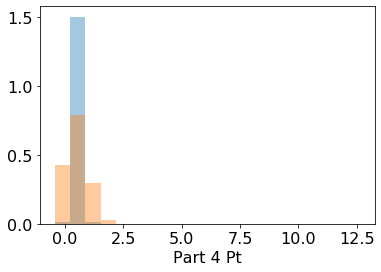

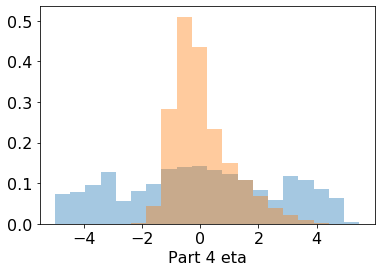

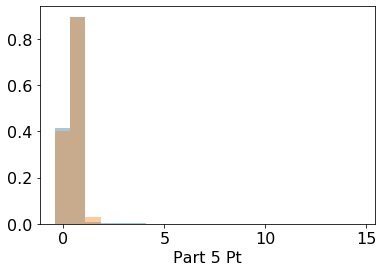

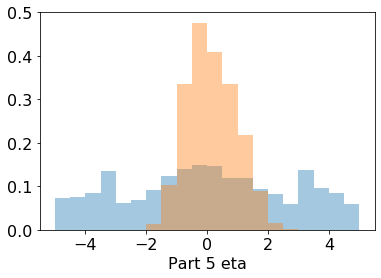

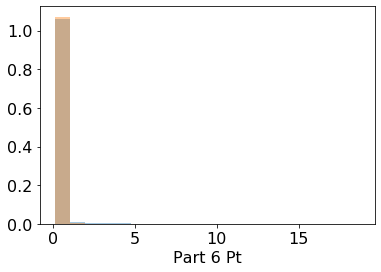

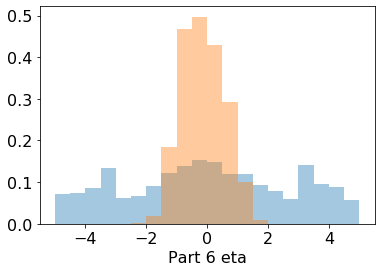

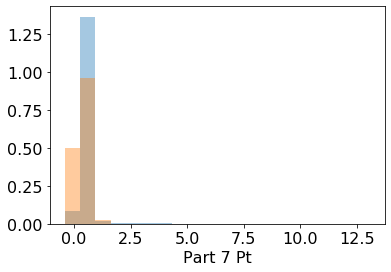

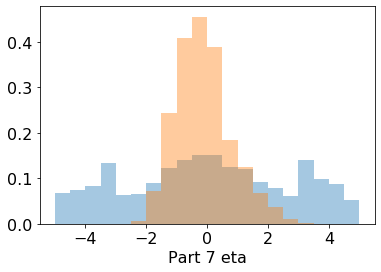

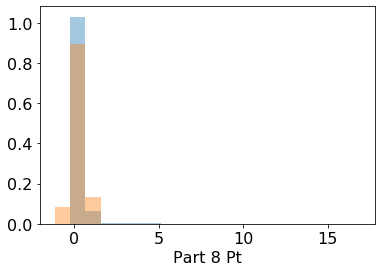

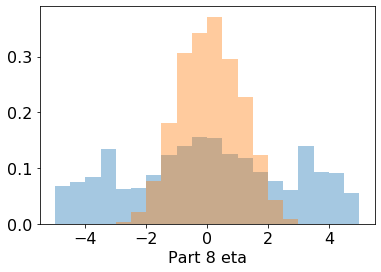

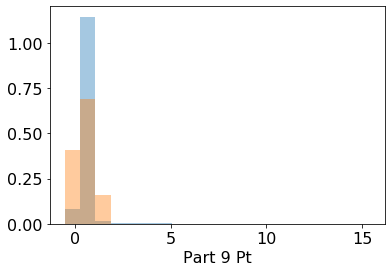

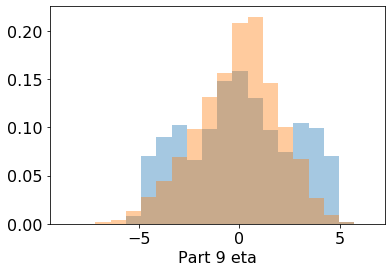

In [18]:
for i in range(x_prime.shape[1]):
    x_aux = x[:,i].flatten()
    xp_aux = x_prime[:,i].flatten()
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('Part {:.0f} '.format(int(i/2)) + dataset['train'].feature_names[i%2])
    dnd.append(f)